# المكتبات

In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# تحميل الملف

review_data= pd.read_csv("...\\Pre-islamic.csv")
print(review_data.head(2))
print(len(review_data))

   id  Score                                               Text
0   1      1  الا هبي بصحنك فاصبحينا ولا تبقي خمور الاندرينا...
1   2      1  اجمع صحبتي سحر ارتحالا ولم اشعر بين منك هالا و...
1461


In [3]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [4]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snmuj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
review_data.dropna(axis = 0, how ='any',inplace=True) 
review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=150)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
1    1461
Name: Score, dtype: int64
1461
-------------------------
No of Short reviews
612


# spaCy كلمات الإيقاف وتحميل نموذج

In [6]:
#from nltk.corpus import stopwords
#stop_words = stopwords.words('stopwords-ar')
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
arb_stopwords = set(nltk.corpus.stopwords.words("function-ar"))

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in arb_stopwords])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snmuj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### مكتبة سبايسي للعربية ليست مدربة ومدعومة وقد جُربت ما يخص الإنجليزية
### من المهم تجريب هذا التدريب في العربية لمن يريد 
https://github.com/elsayed-issa/Arabic-News-Summaries 

In [7]:
import spacy
spacy.load("en_core_web_sm")

In [8]:
import en_core_web_sm
nlp = en_core_web_sm.load()

!pip3 install https://github.com/explosion/spacy-models/releases/download/xx_ent_wiki_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [9]:
def lemmatization(texts,allowed_postags=['NOUN']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [10]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

رايت امريء القيس اصفقوا علينا وقالوا اكثر سليم منصور وافناء عامر وسعد والنصور واعصر خذوا حظكم عكرم واذكروا اواصرنا والرحم بالغيب تذكر وانا واياكم نسومكم لمثلان انتم الصلح افقر سمعنا صارخا معجت صوته المراكل ريعان الجميع مخافة نقول جهارا ويحكم تنفروا رسلكم سنعدي وراءكم فتمنعكم ارماحنا ستعذر والا فانا بالشربة فالوي نعقر امات الرباع ونيسر
['وافناء', 'عامر', 'والنصور', 'سمعنا', 'صارخا', 'معجت', 'صوته', 'المراكل', 'ستعذر', 'والا', 'فانا', 'بالشربة', 'فالوي', 'نعقر', 'امات', 'الرباع']


# إنشاء معجم الكلمات ومصفوفة المستند-الكلمة

In [11]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [12]:
# إنشاء هيكل نموذج تخصيص دركليه الكامن
LDA = gensim.models.ldamodel.LdaModel

# بناء النموذج
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [13]:
lda_model.print_topics()

[(0,
  '0.011*"القوم" + 0.011*"الدهر" + 0.007*"فقلت" + 0.007*"ولست" + 0.007*"الانس" + 0.007*"ورايتم" + 0.007*"افواه" + 0.004*"حديث" + 0.004*"تردي" + 0.004*"اضحي"'),
 (1,
  '0.008*"بوادي" + 0.008*"اودي" + 0.004*"يعطف" + 0.004*"القوم" + 0.004*"الحديد" + 0.004*"الشباب" + 0.004*"علمت" + 0.004*"تخفق" + 0.004*"ماوان" + 0.004*"تهوي"'),
 (2,
  '0.009*"القوم" + 0.009*"الماء" + 0.009*"وقلت" + 0.009*"والقوم" + 0.009*"الشنفري" + 0.005*"الحديد" + 0.005*"الشيب" + 0.005*"وطعنة" + 0.005*"الخيل" + 0.005*"كريم"'),
 (3,
  '0.018*"غداة" + 0.009*"الوجيف" + 0.009*"مكلب" + 0.005*"الحديد" + 0.005*"ودونها" + 0.005*"حفية" + 0.005*"المسير" + 0.005*"فعلا" + 0.005*"الاعراف" + 0.005*"رءيسهم"'),
 (4,
  '0.008*"القوم" + 0.004*"الغني" + 0.004*"عذرا" + 0.004*"جزور" + 0.004*"بنفوسكم" + 0.004*"ليبلغ" + 0.004*"فانا" + 0.004*"رغيبة" + 0.004*"مطرح" + 0.004*"المال"'),
 (5,
  '0.008*"ويحكم" + 0.008*"كانها" + 0.008*"الحي" + 0.008*"الراي" + 0.004*"الخيل" + 0.004*"الضحي" + 0.004*"يطير" + 0.004*"واذا" + 0.004*"القوم" + 0.004*"كرا

In [14]:
# تمثيل الموضوعات
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\snmuj\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.184332 -0.041219       1        1  15.578115
6      0.060198 -0.138455       2        1  11.105512
0      0.003768  0.093843       3        1  10.592888
8      0.041021  0.016374       4        1  10.479311
4      0.026130 -0.039410       5        1   9.672578
5     -0.011613  0.051366       6        1   9.335151
7      0.037978  0.018403       7        1   9.153515
1      0.009946  0.020146       8        1   8.752174
2      0.021953  0.019785       9        1   7.923607
3     -0.005048 -0.000834      10        1   7.407150, topic_info=       Term      Freq     Total Category  logprob  loglift
414    غداة  7.000000  7.000000  Default  30.0000  30.0000
156   الدهر  8.000000  8.000000  Default  29.0000  29.0000
294   الموت  3.000000  3.000000  Default  28.0000  28.0000
311    ابلغ  4.000000  4.000000  Default  27.0000  27.0000
222   الماء  2.000000  2.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
414    غداة  1.884898  7.288565  Topic10  -4.0379   1.2503
55   الحديد  0.505684  2.483935  Topic10  -5.3536   1.0110
66   ودونها  0.505684  1.546496  Topic10  -5.3536   1.4849
548  متونها  0.505683  1.532076  Topic10  -5.3536   1.4943
61     زيدا  0.505683  1.498121  Topic10  -5.3536   1.5167

[412 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
311       1  0.200303    ابلغ
311       3  0.200303    ابلغ
311       4  0.400607    ابلغ
311       6  0.200303    ابلغ
311       8  0.200303    ابلغ
...     ...       ...     ...
190       6  0.631484    يطير
93        6  0.962776  يعرفوا
974       4  0.634314    يعطف
974       8  0.634314    يعطف
900       8  0.969358    يمسي

[464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 1, 9, 5, 6, 8, 2, 3, 4])

In [15]:
# حساب البربلكسيتي (لقياس جودة النموذج، وكلما كان أقل كان ذلك أفضل)
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))

# Coherence Score حساب درجة التماسك
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.410861224960289

Coherence Score:  0.49602290673946037


***
منهج استخراج الرقم الأمثل لعدد الموضوعات

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
***

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=1, limit=11, step=1)

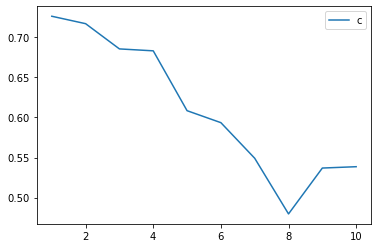

In [18]:
# تمثيل عدد الموضوعات في المحور السيني ودرجة التماسك في المحور الصادي
limit=11; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# استخراج درجات التماسك لعدد الموضوعات
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.7264
Num Topics = 2  has Coherence Value of 0.7171
Num Topics = 3  has Coherence Value of 0.6856
Num Topics = 4  has Coherence Value of 0.6832
Num Topics = 5  has Coherence Value of 0.6085
Num Topics = 6  has Coherence Value of 0.5935
Num Topics = 7  has Coherence Value of 0.5491
Num Topics = 8  has Coherence Value of 0.4796
Num Topics = 9  has Coherence Value of 0.5369
Num Topics = 10  has Coherence Value of 0.5386


In [20]:
# اختيار عدد الموضوعات المراد تخصيصها
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.014*"القوم" + 0.009*"غداة" + 0.009*"الدهر" + 0.009*"ولست" + 0.005*"يعدو" + 0.005*"الجنان" + 0.005*"شعثا" + 0.005*"فضاء" + 0.005*"الجارات" + 0.005*"لابطال"'),
 (1,
  '0.013*"القوم" + 0.013*"الدهر" + 0.008*"الشنفري" + 0.008*"الوجيف" + 0.004*"موكب" + 0.004*"الحديد" + 0.004*"العشي" + 0.004*"عانسا" + 0.004*"الماء" + 0.004*"الدري"'),
 (2,
  '0.025*"غداة" + 0.009*"يطير" + 0.009*"القوم" + 0.005*"رجالا" + 0.005*"الخيل" + 0.004*"الاكفاء" + 0.004*"لهياج" + 0.004*"المظالم" + 0.004*"تجلي" + 0.004*"البيت"'),
 (3,
  '0.006*"القوم" + 0.006*"المنايا" + 0.006*"كانها" + 0.006*"الضحي" + 0.006*"الدهر" + 0.006*"اودي" + 0.006*"ويحكم" + 0.003*"ومباءض" + 0.003*"تفرق" + 0.003*"سوالفها"'),
 (4,
  '0.008*"تهوي" + 0.008*"يعطف" + 0.004*"الشباب" + 0.004*"بوادي" + 0.004*"ترجف" + 0.004*"الارض" + 0.004*"الحمد" + 0.004*"زعموا" + 0.004*"الحديد" + 0.004*"العالمون"'),
 (5,
  '0.010*"اليوم" + 0.006*"كانما" + 0.003*"اولي" + 0.003*"قريح" + 0.003*"تهتصر" + 0.003*"حمال" + 0.003*"ترجف" + 0.003*"الشوارا" + 0.003*"سمانها

In [21]:
# تمثيل الموضوعات والكلمات
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\snmuj\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.103203  0.114780       1        1  14.826488
3     -0.164806  0.025773       2        1  14.026067
8      0.050695 -0.155962       3        1  12.415440
4     -0.011704  0.017659       4        1   9.588970
7      0.018831  0.020875       5        1   9.544167
6      0.015683 -0.021164       6        1   8.846287
1     -0.014385 -0.022524       7        1   8.461679
2     -0.014759  0.009604       8        1   7.785783
9      0.028008  0.010047       9        1   7.625157
0     -0.010765  0.000912      10        1   6.879962, topic_info=      Term      Freq     Total Category  logprob  loglift
414   غداة  6.000000  6.000000  Default  30.0000  30.0000
311   ابلغ  4.000000  4.000000  Default  29.0000  29.0000
68   القوم  8.000000  8.000000  Default  28.0000  28.0000
156  الدهر  8.000000  8.000000  Default  27.0000  27.0000
250   وقلت  2.000000  2.000000  Default  26.0000  26.0000
..     ...       ...       ...      ...      ...      ...
483   شعثا  0.490487  1.427284  Topic10  -5.3103   1.6084
623  تركنا  0.490478  1.499943  Topic10  -5.3103   1.5588
474  كانها  0.490477  3.643703  Topic10  -5.3103   0.6712
73   الخيل  0.490466  2.983507  Topic10  -5.3103   0.8711
363  الارض  0.490455  1.500560  Topic10  -5.3103   1.5583

[414 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
311       2  0.217460    ابلغ
311       5  0.217460    ابلغ
311       6  0.434920    ابلغ
311       7  0.217460    ابلغ
1002      9  1.011337   اجابه
...     ...       ...     ...
190       8  0.695289    يطير
1192      2  0.892089  يظلمها
974       4  0.631010    يعطف
1099      7  0.982117   يغرنك
909       3  0.910589    ينسي

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 9, 5, 8, 7, 2, 3, 10, 1])